In [1]:
import pandas as pd
from collections import Counter
import re
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Reading NYT dataset
df_nyt = pd.read_csv("/home/sathyanarayanan/Desktop/NLP project/FAKE NEWS DETECTION/Cleaning Data/NYT_final.csv", engine='python')

In [3]:
df_nyt.head(5)

,Unnamed: 0,index,level_0,_id,body,keywords,lead_paragraph,pub_date,section_name,word_count,head_clean
0,0,0,0,5ab988e147de81a9012179ae,As mourners prepare to gather on Tuesday to pa...,"[{""name"":""subject"",""value"":""Fires and Firefigh...",NaN,2018-03-26T23:57:17+0000,NaN,821,Building Where Firefighter Died Will Be Demoli...
1,1,1,1,5ab987d747de81a9012179a6,SEOUL — General Motors said its loss-making S...,[],NaN,2018-03-26T23:52:51+0000,NaN,481,Says South Korean Unit Will File for Bankruptc...
2,2,2,2,5ab9872747de81a9012179a1,"(Reuters) - FX Networks, a unit of Twenty-Firs...",[],NaN,2018-03-26T23:49:55+0000,NaN,413,De Havillands Feud Lawsuit Against FX Networks...
3,3,3,3,5ab9867f47de81a901217999,LAS VEGAS — Five members of the MS-13 street ...,[],NaN,2018-03-26T23:47:08+0000,NaN,429,Police Say 5 Arrests in MS-13 Case Solves 10 M...
4,4,4,4,5ab9866f47de81a901217996,(Reuters) - Suspicious packages were found at ...,[],NaN,2018-03-26T23:46:51+0000,NaN,181,"Packages Found at U.S. Installations in D.C."""


In [4]:
# Adding label to real news to the dataset and showing the column names
df_nyt["fakeness"] = 0
df_nyt.columns

Index(['Unnamed: 0', 'index', 'level_0', '_id', 'body', 'keywords',
       'lead_paragraph', 'pub_date', 'section_name', 'word_count',
       'head_clean', 'fakeness'],
      dtype='object')

In [5]:
df_nyt=df_nyt.drop(['level_0'], axis=1)

In [6]:
df_nyt.columns

Index(['Unnamed: 0', 'index', '_id', 'body', 'keywords', 'lead_paragraph',
       'pub_date', 'section_name', 'word_count', 'head_clean', 'fakeness'],
      dtype='object')

In [7]:
print("The number of articles in NYT dataset are "+str(df_nyt.shape[0]))

The number of articles in NYT dataset are 8382


In [8]:
import sys
import csv

In [9]:
csv.field_size_limit(sys.maxsize)

131072

In [10]:
# Reading The Guardian dataset
df_tguard = pd.read_csv("/home/sathyanarayanan/Desktop/NLP project/FAKE NEWS DETECTION/Cleaning Data/Clean_TheGuardian_Combined_No_Slash.csv",engine='python',error_bad_lines=False)

In [11]:
# Adding label to real news to the dataset and showing the column names
df_tguard["fakeness"] = 0
df_tguard.columns

Index(['Unnamed: 0', 'apiUrl', 'fields', 'id', 'isHosted', 'pillarId',
       'pillarName', 'sectionId', 'sectionName', 'type', 'webPublicationDate',
       'webTitle', 'webUrl', 'bodyText', 'headline', 'fakeness'],
      dtype='object')

In [12]:
df_tguard=df_tguard.drop(['pillarId','pillarName'], axis=1)

In [13]:
df_tguard.columns

Index(['Unnamed: 0', 'apiUrl', 'fields', 'id', 'isHosted', 'sectionId',
       'sectionName', 'type', 'webPublicationDate', 'webTitle', 'webUrl',
       'bodyText', 'headline', 'fakeness'],
      dtype='object')

In [14]:
df_fake = pd.read_csv("/home/sathyanarayanan/Desktop/NLP project/FAKE NEWS DETECTION/Cleaning Data/FakeNews_Clean_All.csv", engine='python')

In [15]:
# Label was there for fake news dataset and showing the column names
df_fake.columns

Index(['Unnamed: 0', 'uuid', 'ord_in_thread', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'thread_title',
       'spam_score', 'replies_count', 'participants_count', 'likes',
       'comments', 'shares', 'type', 'fakeness'],
      dtype='object')

In [16]:
# Changing the name of the column for concating later
df_tguard = df_tguard.rename(columns={'bodyText' : 'body','webPublicationDate':'pub_date'})
df_nyt = df_nyt.rename(columns={'head_clean':'headline','_id':'id'})
df_fake = df_fake.rename(columns={'text':'body','title':'headline','uuid':'id','published':'pub_date'})
df_fake.columns,df_nyt.columns,df_tguard.columns

(Index(['Unnamed: 0', 'id', 'ord_in_thread', 'pub_date', 'headline', 'body',
        'language', 'crawled', 'site_url', 'country', 'thread_title',
        'spam_score', 'replies_count', 'participants_count', 'likes',
        'comments', 'shares', 'type', 'fakeness'],
       dtype='object'),
 Index(['Unnamed: 0', 'index', 'id', 'body', 'keywords', 'lead_paragraph',
        'pub_date', 'section_name', 'word_count', 'headline', 'fakeness'],
       dtype='object'),
 Index(['Unnamed: 0', 'apiUrl', 'fields', 'id', 'isHosted', 'sectionId',
        'sectionName', 'type', 'pub_date', 'webTitle', 'webUrl', 'body',
        'headline', 'fakeness'],
       dtype='object'))

In [17]:
# Dropping unnecesary columns
df_fake.drop(['Unnamed: 0', 'ord_in_thread', 
         'language', 'crawled', 'site_url', 'country',
        'thread_title', 'spam_score', 'replies_count', 'participants_count',
        'likes', 'comments', 'shares', 'type'],inplace=True,axis=1)

df_nyt.drop(['Unnamed: 0', 'index',  'keywords',
        'lead_paragraph', 'section_name', 'word_count'],inplace=True,axis=1)

df_tguard.drop(['Unnamed: 0', 'apiUrl', 'fields', 
        'isHosted', 'sectionId', 'sectionName', 'type',
         'webTitle', 'webUrl'],inplace=True,axis=1)

In [18]:
print("The number of genuine articles in kaggle dataset are "+str(df_fake.shape[0]))

The number of genuine articles in kaggle dataset are 11841


In [19]:
df_fake.head()

,id,pub_date,headline,body,fakeness
0,6a175f46bcd24d39b3e962ad0f29936721db70db,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Govt Be...,Print They should pay all the back all the mon...,1
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,1
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,1
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,1
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1


In [20]:

# Overview for data
df_nyt.head()

,id,body,pub_date,headline,fakeness
0,5ab988e147de81a9012179ae,As mourners prepare to gather on Tuesday to pa...,2018-03-26T23:57:17+0000,Building Where Firefighter Died Will Be Demoli...,0
1,5ab987d747de81a9012179a6,SEOUL — General Motors said its loss-making S...,2018-03-26T23:52:51+0000,Says South Korean Unit Will File for Bankruptc...,0
2,5ab9872747de81a9012179a1,"(Reuters) - FX Networks, a unit of Twenty-Firs...",2018-03-26T23:49:55+0000,De Havillands Feud Lawsuit Against FX Networks...,0
3,5ab9867f47de81a901217999,LAS VEGAS — Five members of the MS-13 street ...,2018-03-26T23:47:08+0000,Police Say 5 Arrests in MS-13 Case Solves 10 M...,0
4,5ab9866f47de81a901217996,(Reuters) - Suspicious packages were found at ...,2018-03-26T23:46:51+0000,"Packages Found at U.S. Installations in D.C.""",0


In [21]:
print("The number of articles in Gaurdian dataset are "+str(df_tguard.shape[0]))

The number of articles in Gaurdian dataset are 19998


In [22]:
# Overview for data
df_tguard.head()

,id,pub_date,body,headline,fakeness
0,business/2016/may/02/english-businesses-should...,2016-05-01T23:01:08Z,All premises in England that sell food should ...,English businesses 'should be forced to show h...,0
1,business/2016/may/02/tips-should-go-to-workers...,2016-05-01T23:01:07Z,"Tips in restaurants, hotels and bars should go...","Tips should go to workers, not employers, says...",0
2,politics/blog/live/2016/may/01/scottish-electi...,2016-05-01T21:51:50Z,Election debates are more common in Holyrood p...,Sturgeon accused of breaking independence prom...,0
3,politics/2016/may/01/scottish-independence-vot...,2016-05-01T21:40:37Z,Nicola Sturgeon has said a second independence...,Second Scottish independence vote not yet on t...,0
4,us-news/2016/may/01/bernie-sanders-contested-c...,2016-05-01T21:16:57Z,Bernie Sanders acknowledged �an uphill climb� ...,Bernie Sanders vows a contested convention des...,0


In [23]:
# Concat the datasents
df_all = df_fake.append(df_tguard, ignore_index=True)
df_all = df_all.append(df_nyt,ignore_index=True)

In [24]:
#Dropping the Nan values and info
df_all.dropna(inplace=True)
print(df_all.shape)
df_all.info()

(40006, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40006 entries, 0 to 40220
Data columns (total 5 columns):
body        40006 non-null object
fakeness    40006 non-null int64
headline    40006 non-null object
id          40006 non-null object
pub_date    40006 non-null object
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [25]:
df_all.head()

,body,fakeness,headline,id,pub_date
0,Print They should pay all the back all the mon...,1,Muslims BUSTED: They Stole Millions In Govt Be...,6a175f46bcd24d39b3e962ad0f29936721db70db,2016-10-26T21:41:00.000+03:00
1,Why Did Attorney General Loretta Lynch Plead T...,1,Re: Why Did Attorney General Loretta Lynch Ple...,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,2016-10-29T08:47:11.259+03:00
2,Red State : \nFox News Sunday reported this mo...,1,BREAKING: Weiner Cooperating With FBI On Hilla...,c70e149fdd53de5e61c29281100b9de0ed268bc3,2016-10-31T01:41:49.479+02:00
3,Email Kayla Mueller was a prisoner and torture...,1,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,7cf7c15731ac2a116dd7f629bd57ea468ed70284,2016-11-01T05:22:00.000+02:00
4,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0206b54719c7e241ffe0ad4315b808290dbe6c0f,2016-11-01T21:56:00.000+02:00


In [26]:
df_all.to_csv("/home/sathyanarayanan/Desktop/NLP project/FAKE NEWS DETECTION/Complete_DataSet_Clean.csv")

In [27]:
#modeling

In [28]:
# Preparing the target and predictors for modeling

X_body_text = df_all.body.values
X_headline_text = df_all.headline.values
y = df_all.fakeness.values

In [29]:
tfidf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.85, min_df= 0.01)

In [30]:
X_body_tfidf = tfidf.fit_transform(X_body_text)
X_headline_tfidf = tfidf.fit_transform (X_headline_text)

In [31]:
X_headline_tfidf_train, X_headline_tfidf_test, y_headline_train, y_headline_test = train_test_split(X_headline_tfidf,y, test_size = 0.2, random_state=1234)
X_body_tfidf_train, X_body_tfidf_test, y_body_train, y_body_test = train_test_split(X_body_tfidf,y, test_size = 0.2, random_state=1234)

In [32]:
#learning curve

In [33]:
class cross_validation(object):
    '''This class provides cross validation of any data set why incrementally increasing number 
       of samples in the training and test set and performing KFold splits at every iteration. 
       During cross validation the metrics accuracy, recall, precision, and f1-score are recored. 
       The results of the cross validation are display on four learning curves. '''
    
    def __init__(self, model, X_data, Y_data, X_test=None, Y_test=None, 
                 n_splits=3, init_chunk_size = 1000000, chunk_spacings = 100000, average = "binary"):

        self.X, self.Y =  shuffle(X_data, Y_data, random_state=1234)
        
        
        self.model = model
        self.n_splits = n_splits
        self.chunk_size = init_chunk_size
        self.chunk_spacings = chunk_spacings        
        
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.X_holdout = []
        self.Y_holdout = []
        
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []
        
        self.f1_mean_train = []
        self.f1_mean_test = []
        self.acc_mean_train = []
        self.acc_mean_test = []
        self.pre_mean_train = []
        self.pre_mean_test = []
        self.rec_mean_train = []
        self.rec_mean_test = []
        
        self.training_size = []
        self.averageType = average
    
    def make_chunks(self):
        '''Partitions data into chunks for incremental cross validation'''
        
        # get total number of points
        self.N_total = self.X.shape[0]
        # partition data into chunks for learning
        self.chunks = list(np.arange(self.chunk_size, self.N_total, self.chunk_spacings ))
        self.remainder = self.X.shape[0] - self.chunks[-1]
        self.chunks.append( self.chunks[-1] + self.remainder )



    def train_for_learning_curve(self):
        '''KFold cross validates model and records metric scores for learning curves. 
           Metrics scored are f1-score, precision, recall, and accuracy'''

        # partiton data into chunks 
        self.make_chunks()
        # for each iteration, allow the model to use 10 more samples in the training set 
        self.skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=1234)
        # iterate through the first n samples
        for n_points in self.chunks: 
            
        
            # split the first n samples in k folds 
            for train_index, test_index in self.skf.split(self.X[:n_points], self.Y[:n_points]):
                self.train_index, self.test_index = train_index, test_index                
                self.X_train = self.X[self.train_index]
                self.X_test = self.X[self.test_index]
                self.Y_train = self.Y[self.train_index]
                self.Y_test = self.Y[self.test_index]
                
                self.model.fit(self.X_train, self.Y_train)
                self.y_pred_train = self.model.predict(self.X_train)
                self.y_pred_test = self.model.predict(self.X_test)
                self.log_metric_scores_()   
                
            self.log_metric_score_means_()
            self.training_size.append(n_points)
        
    def validate_for_holdout_set(self, X_holdout, Y_holdout):
        
        
        self.X_test = X_holdout
        self.Y_test = Y_holdout
        
        # partiton data into chunks 
        self.make_chunks()
        
        for n_points in self.chunks:
            
            self.X_train = self.X[:n_points]
            self.Y_train = self.Y[:n_points]

            self.model.fit(self.X_train, self.Y_train)
            self.y_pred_train = self.model.predict(self.X_train)
            self.y_pred_test = self.model.predict(self.X_test)
            self.log_metric_scores_()   

            self.log_metric_score_means_()
            self.training_size.append(n_points)
            
            
    
                            
    def log_metric_score_means_(self):
        '''Recrods the mean of the four metrics recording during training'''
        self.f1_mean_train.append(np.sum(self.f1_train)/len(self.f1_train))
        self.f1_mean_test.append(np.sum(self.f1_test)/len(self.f1_test))
        
        self.acc_mean_train.append(np.sum(self.acc_train)/len(self.acc_train))
        self.acc_mean_test.append(np.sum(self.acc_test)/len(self.acc_test))
        
        self.pre_mean_train.append(np.sum(self.pre_train)/len(self.pre_train))
        self.pre_mean_test.append(np.sum(self.pre_test)/len(self.pre_test))
        
        self.rec_mean_train.append(np.sum(self.rec_train)/len(self.rec_train))
        self.rec_mean_test.append(np.sum(self.rec_test)/len(self.rec_test))
        
        self.reinitialize_metric_lists_()
            
            
    def reinitialize_metric_lists_(self):
        '''Reinitializes metrics lists for training'''
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

            
    def log_metric_scores_(self):
        '''Records the metric scores during each training iteration'''
        self.f1_train.append(f1_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.acc_train.append(accuracy_score( self.Y_train, self.y_pred_train) )

        self.pre_train.append(precision_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.rec_train.append(recall_score( self.Y_train, self.y_pred_train, average=self.averageType) )

        self.f1_test.append(f1_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.acc_test.append(accuracy_score(self.Y_test, self.y_pred_test))

        self.pre_test.append(precision_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.rec_test.append(recall_score(self.Y_test, self.y_pred_test,average=self.averageType))
            

    def plot_learning_curve(self):
        '''Plots f1 and accuracy learning curves for a given model and data set'''
        
        fig = plt.figure(figsize = (17,12))
        # plot f1 score learning curve
        fig.add_subplot(221)   # left
        plt.title("F1-Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.f1_mean_train, label="Train")
        plt.plot(self.training_size, self.f1_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("F1-Score")
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(222)   # right 
        plt.title("Accuracy vs. Number of Training Samples")
        plt.plot(self.training_size, self.acc_mean_train, label="Train")
        plt.plot(self.training_size, self.acc_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.legend(loc=4);
        
        # plot precision learning curve
        fig.add_subplot(223)   # left
        plt.title("Precision Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.pre_mean_train, label="Train")
        plt.plot(self.training_size, self.pre_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Precision")
        plt.ylim(min(self.pre_mean_test), max(self.pre_mean_train) + 0.05)
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(224)   # right 
        plt.title("Recall vs. Number of Training Samples")
        plt.plot(self.training_size, self.rec_mean_train, label="Train")
        plt.plot(self.training_size, self.rec_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Recall")
        plt.legend(loc=4);

In [34]:
#Logistic Regression
#Using the headline of the article

In [35]:
lr_headline = LogisticRegression(penalty='l1')

In [36]:
# train model
lr_headline.fit(X_headline_tfidf_train, y_headline_train)

# get predictions for article section
y_headline_pred = lr_headline.predict(X_headline_tfidf_test)

In [37]:
# print metrics
print ("Logistig Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_headline_pred)*100) )

Logistig Regression F1 and Accuracy Scores : 

F1 score 63.73%
Accuracy score 75.44%


In [38]:
cros_val_list = cross_val_score(lr_headline, X_headline_tfidf,y,cv=7)
print (cros_val_list)
print (cros_val_list.mean())

[0.73337999 0.75279916 0.74492652 0.75083115 0.74995626 0.78438922
 0.76933847]
0.755088679465519


In [39]:
#Learning Curve for headline logistic regression

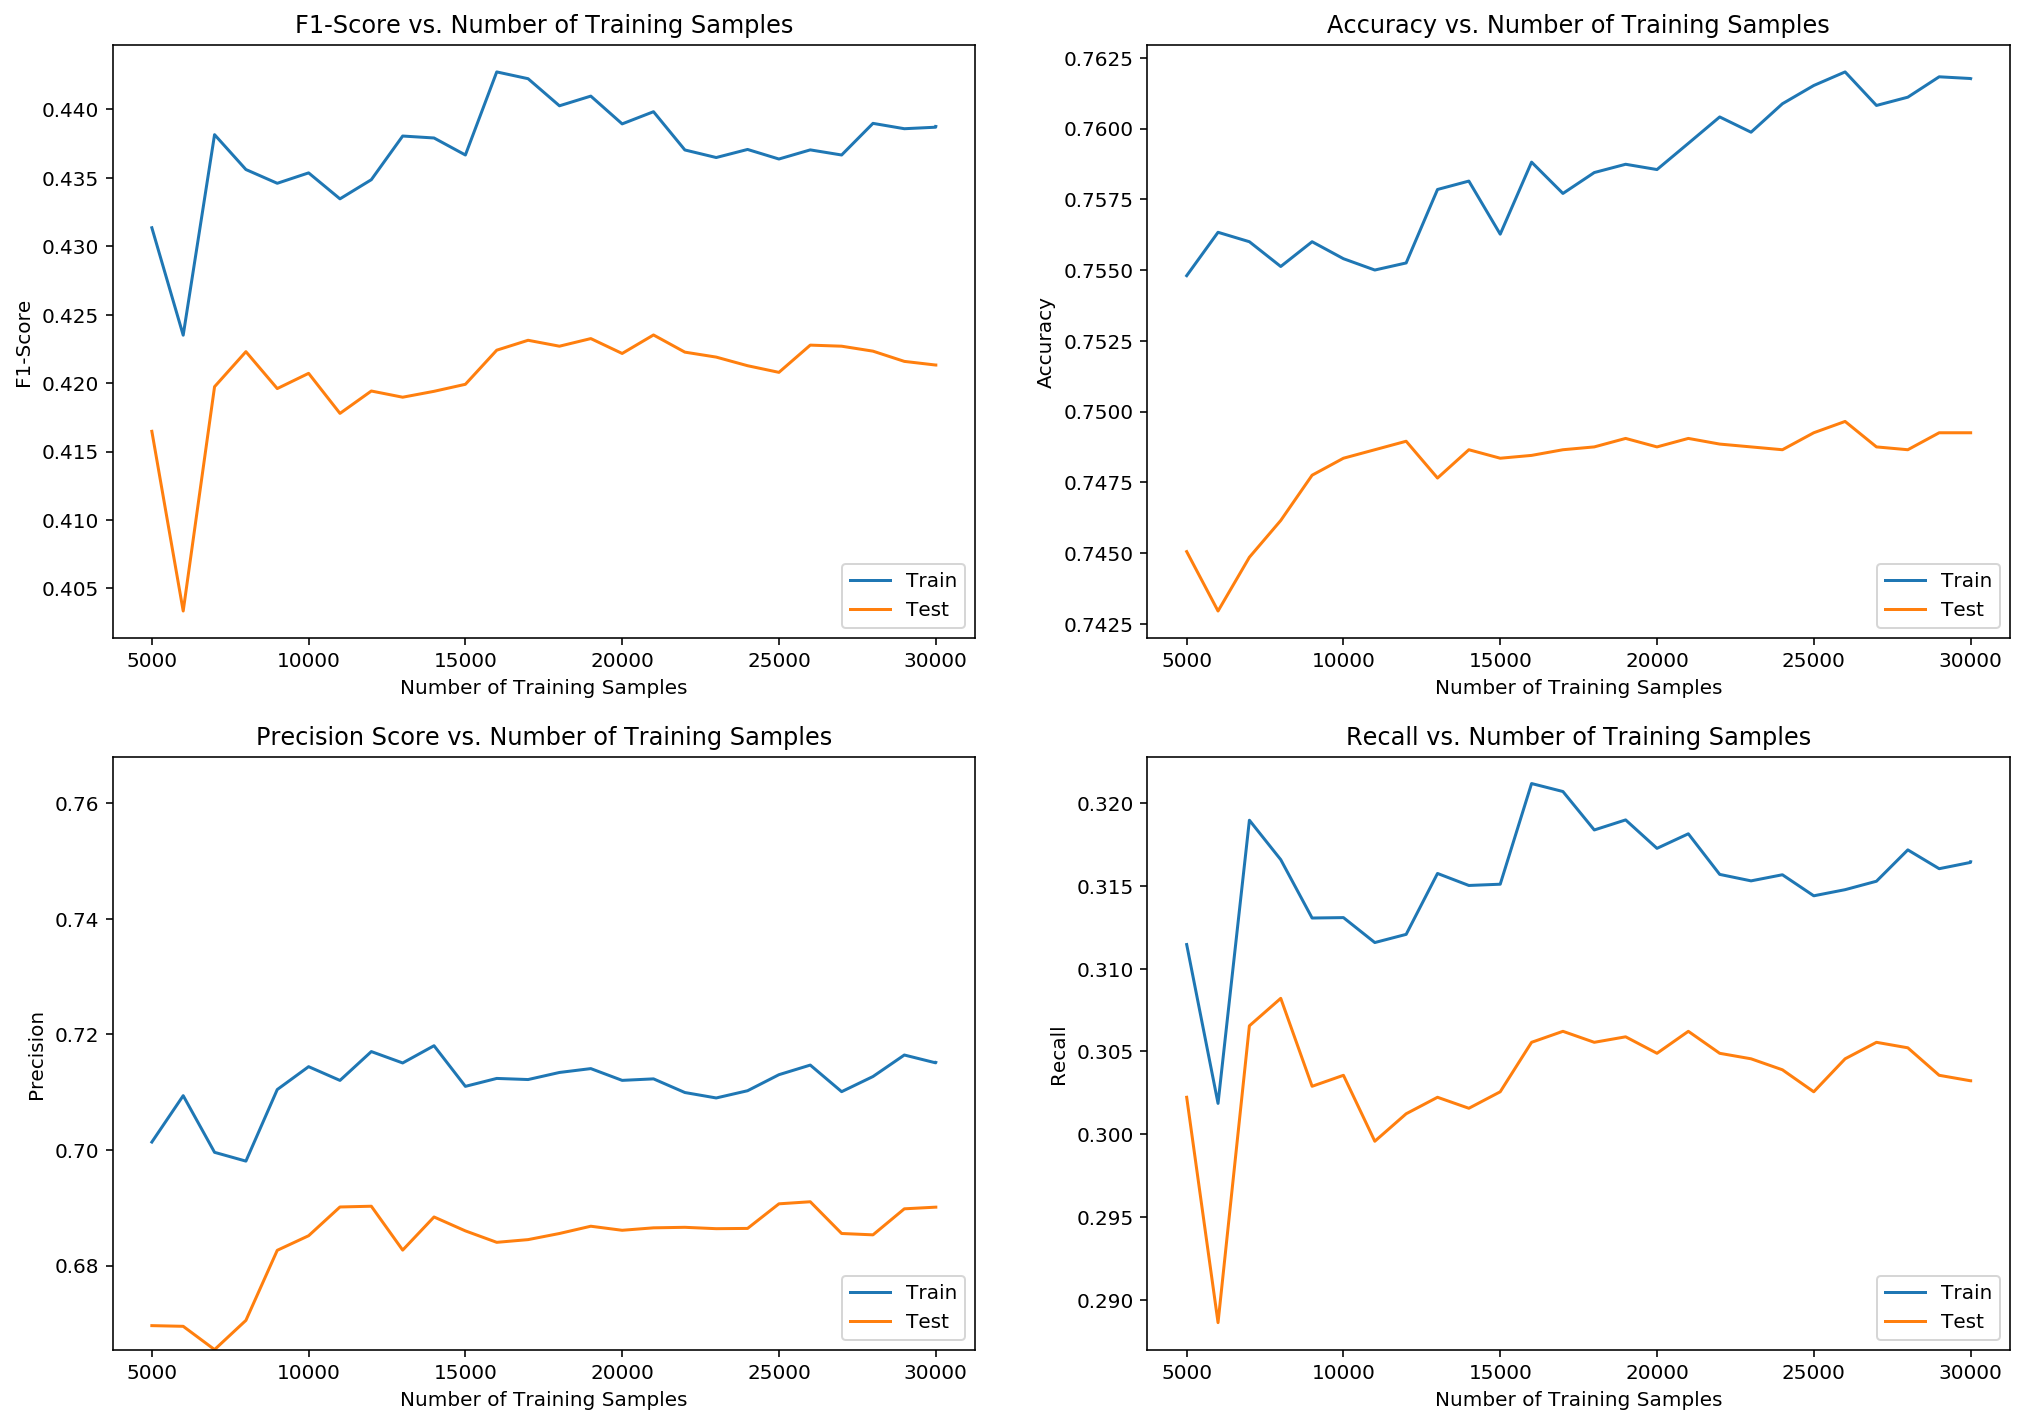

In [40]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(lr_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

In [41]:
#Logistic Regression
#Using Body of the article

In [42]:
lr_body = LogisticRegression(penalty='l1')

In [43]:
# train model
lr_body.fit(X_body_tfidf_train, y_body_train)

# get predictions for article section
y_body_pred = lr_body.predict(X_body_tfidf_test)

In [44]:
# print metrics
print ("Logistig Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_body_test, y_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_body_pred)*100) )

Logistig Regression F1 and Accuracy Scores : 

F1 score 94.66%
Accuracy score 95.58%


In [45]:
cros_val_list = cross_val_score(lr_body, X_body_tfidf,y,cv=7)
print (cros_val_list)
print (cros_val_list.mean())

[0.95311407 0.9576627  0.93701889 0.93718285 0.9399825  0.92422121
 0.89114456]
0.9343323977029618


In [46]:
#Learning Curve for body logistic regression

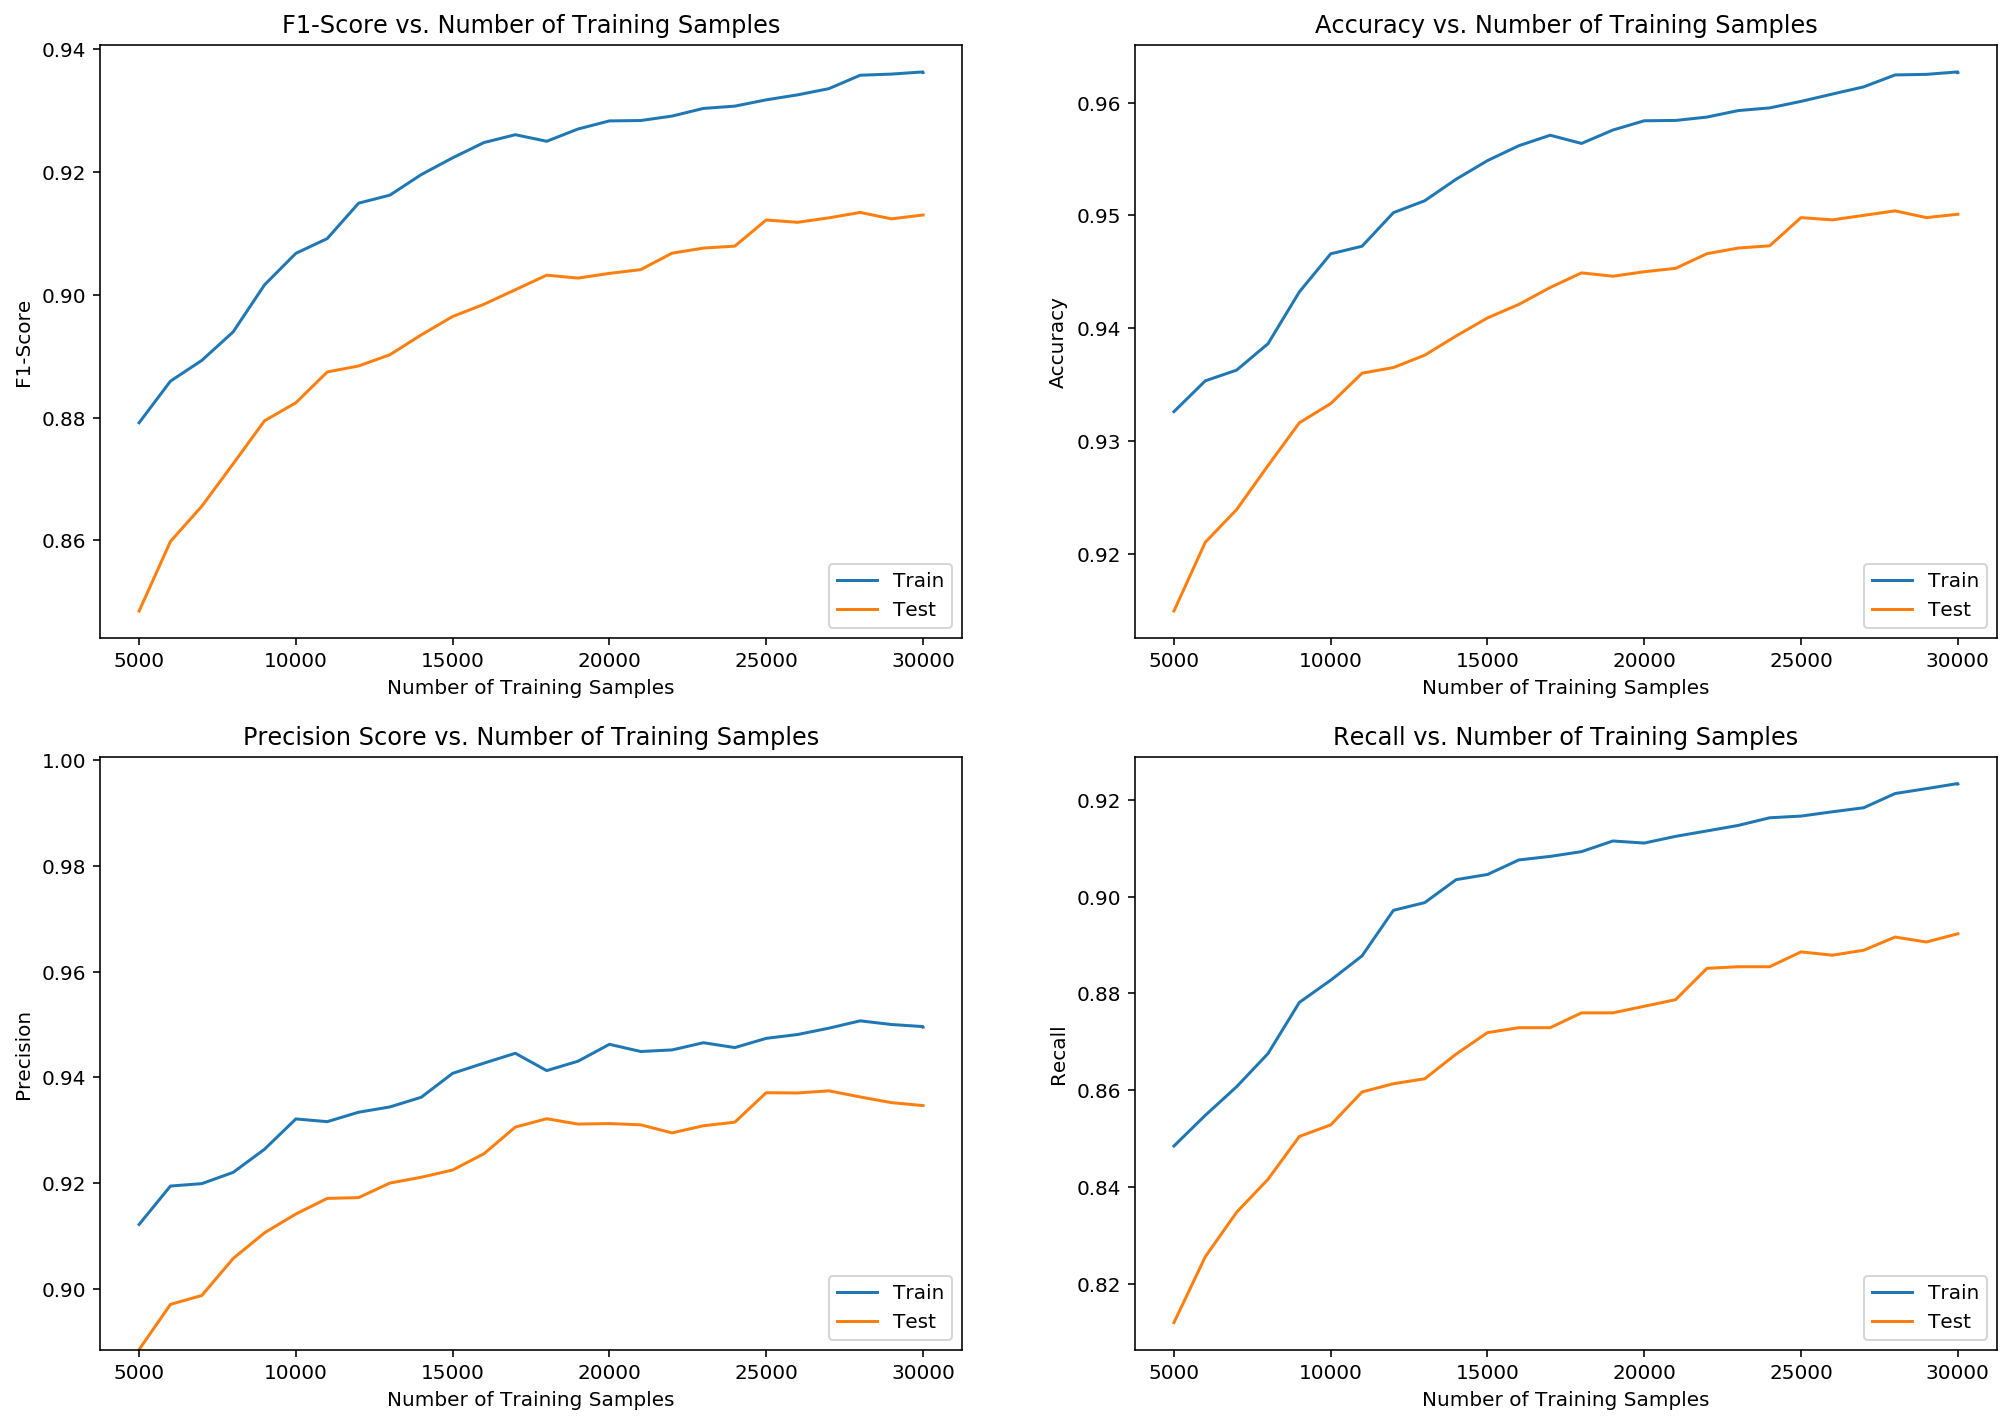

In [47]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(lr_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

In [48]:
#Random Forest
#Using headlines from the dataset

In [49]:
rcf_headline = RandomForestClassifier(n_estimators=100,n_jobs=3)

In [50]:
rcf_headline.fit(X_headline_tfidf_train, y_headline_train)
y_rc_headline_pred = rcf_headline.predict(X_headline_tfidf_test)

In [51]:
# print metrics
print ("Random Forest F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_rc_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_rc_headline_pred)*100) )

Random Forest F1 and Accuracy Scores : 

F1 score 64.39%
Accuracy score 75.87%


In [52]:
cros_val_list = cross_val_score(rcf_headline, X_headline_tfidf,y,cv=5)
print(cros_val_list)
print(cros_val_list.mean())


[0.73206698 0.75653043 0.74490689 0.77102862 0.76927884]
0.7547623530312898


In [53]:
#Learning Curve for headline random forest

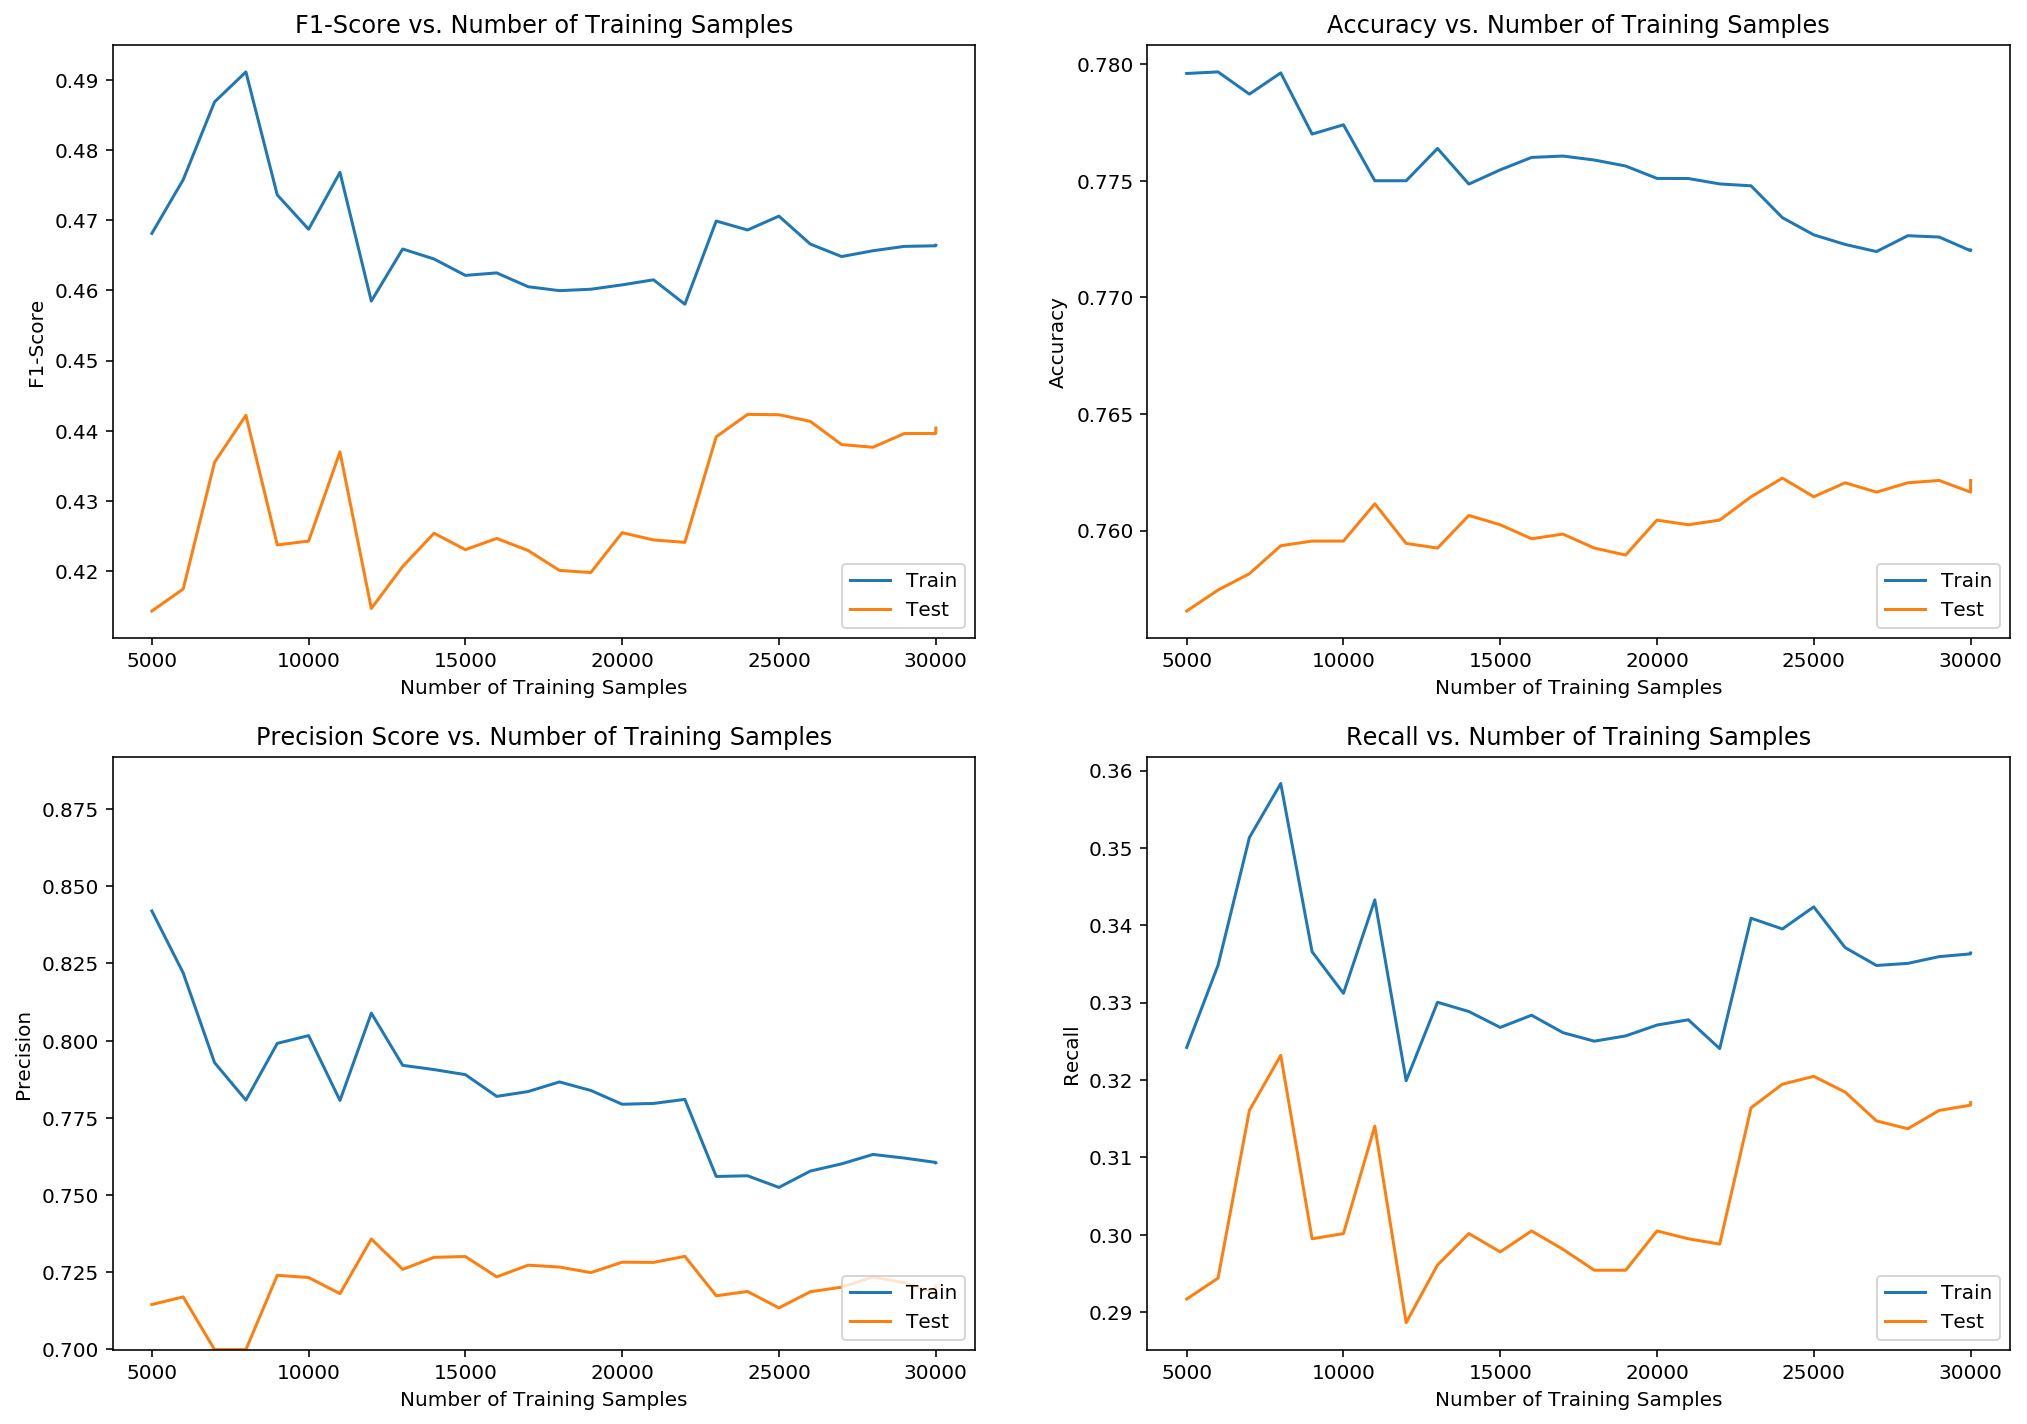

In [54]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(rcf_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

In [55]:
#Random Forest
#Using body from the dataset

In [56]:
rcf_body = RandomForestClassifier(n_estimators=100,n_jobs=3)

In [57]:
rcf_body.fit(X_body_tfidf_train, y_body_train)
y_rc_body_pred = rcf_body.predict(X_body_tfidf_test)

In [58]:
# print metrics
print ("Random Forest F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_body_test, y_rc_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_rc_body_pred)*100) )

Random Forest F1 and Accuracy Scores : 

F1 score 91.62%
Accuracy score 93.34%


In [59]:
#Learning Curve for body random forest

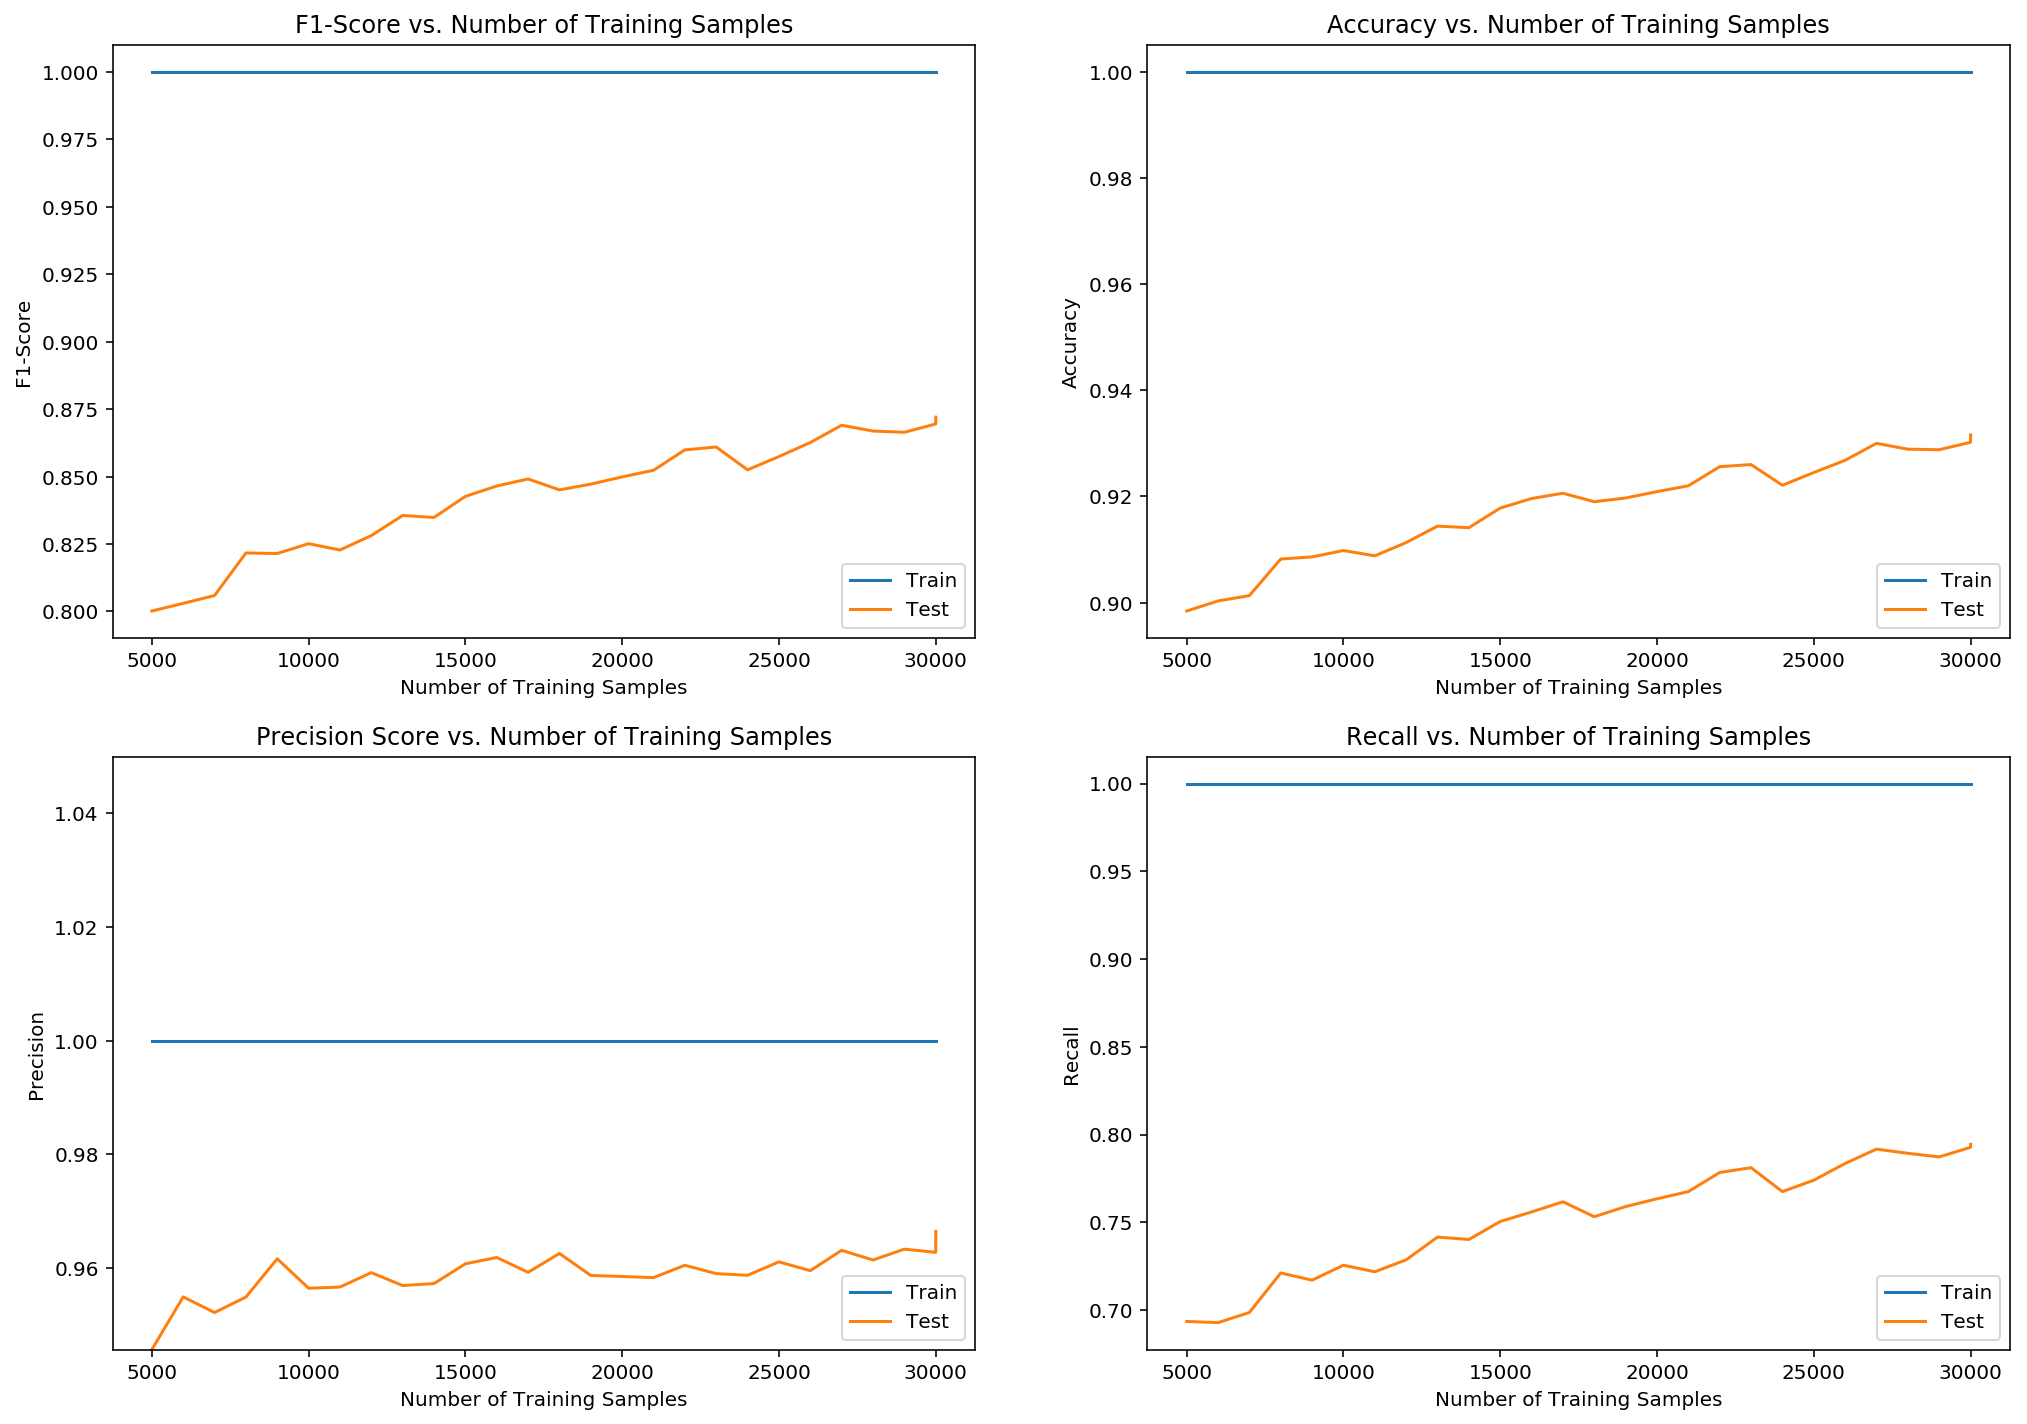

In [60]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(rcf_body, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

In [61]:
#XGBoost Classifier
#Using headlines from the dataset

In [62]:
xgb_headline = XGBClassifier()

In [63]:
xgb_headline.fit(X_headline_tfidf_train, y_headline_train)
y_xgb_headline_pred = xgb_headline.predict(X_headline_tfidf_test)

/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [64]:
# print metrics
print ("XGBoost F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_xgb_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_xgb_headline_pred)*100) )

XGBoost F1 and Accuracy Scores : 

F1 score 61.75%
Accuracy score 75.93%


/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

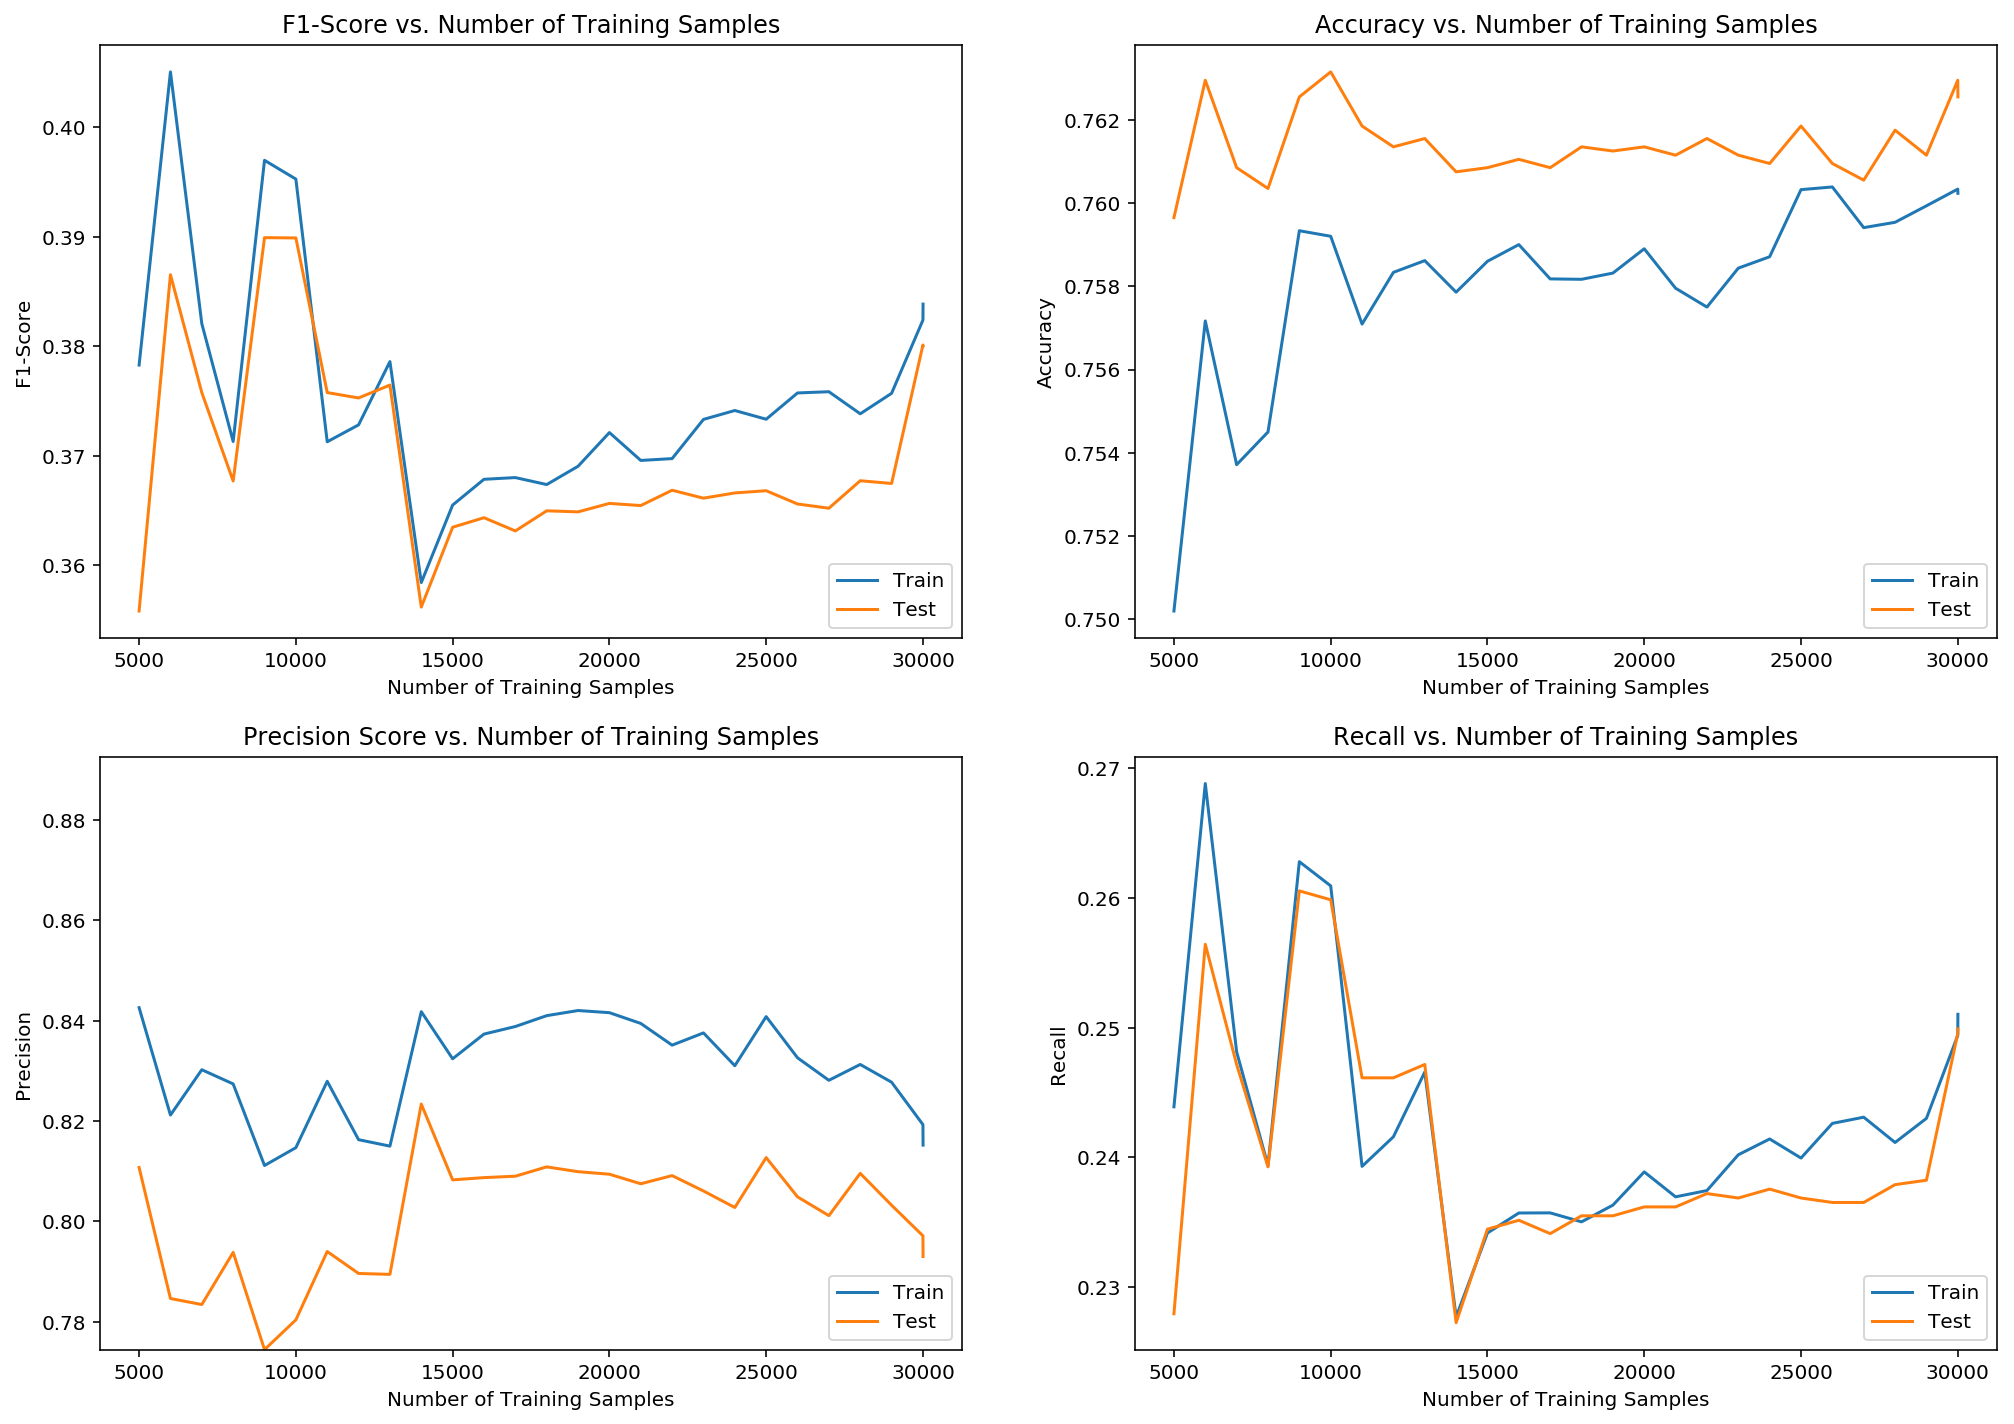

In [65]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(xgb_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

In [66]:

#XGBoost Classifier
#Using body from the dataset

In [67]:
xgb_body = XGBClassifier()

In [68]:
xgb_body.fit(X_body_tfidf_train, y_body_train)
y_xgb_body_pred = xgb_body.predict(X_body_tfidf_test)

/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [69]:
# print metrics
print ("XGBoost F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%``".format( f1_score(y_body_test, y_xgb_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_xgb_body_pred)*100) )

XGBoost F1 and Accuracy Scores : 

F1 score 89.98%``
Accuracy score 91.73%


In [70]:
#Learning Curve for body XGboost

/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathyanarayanan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

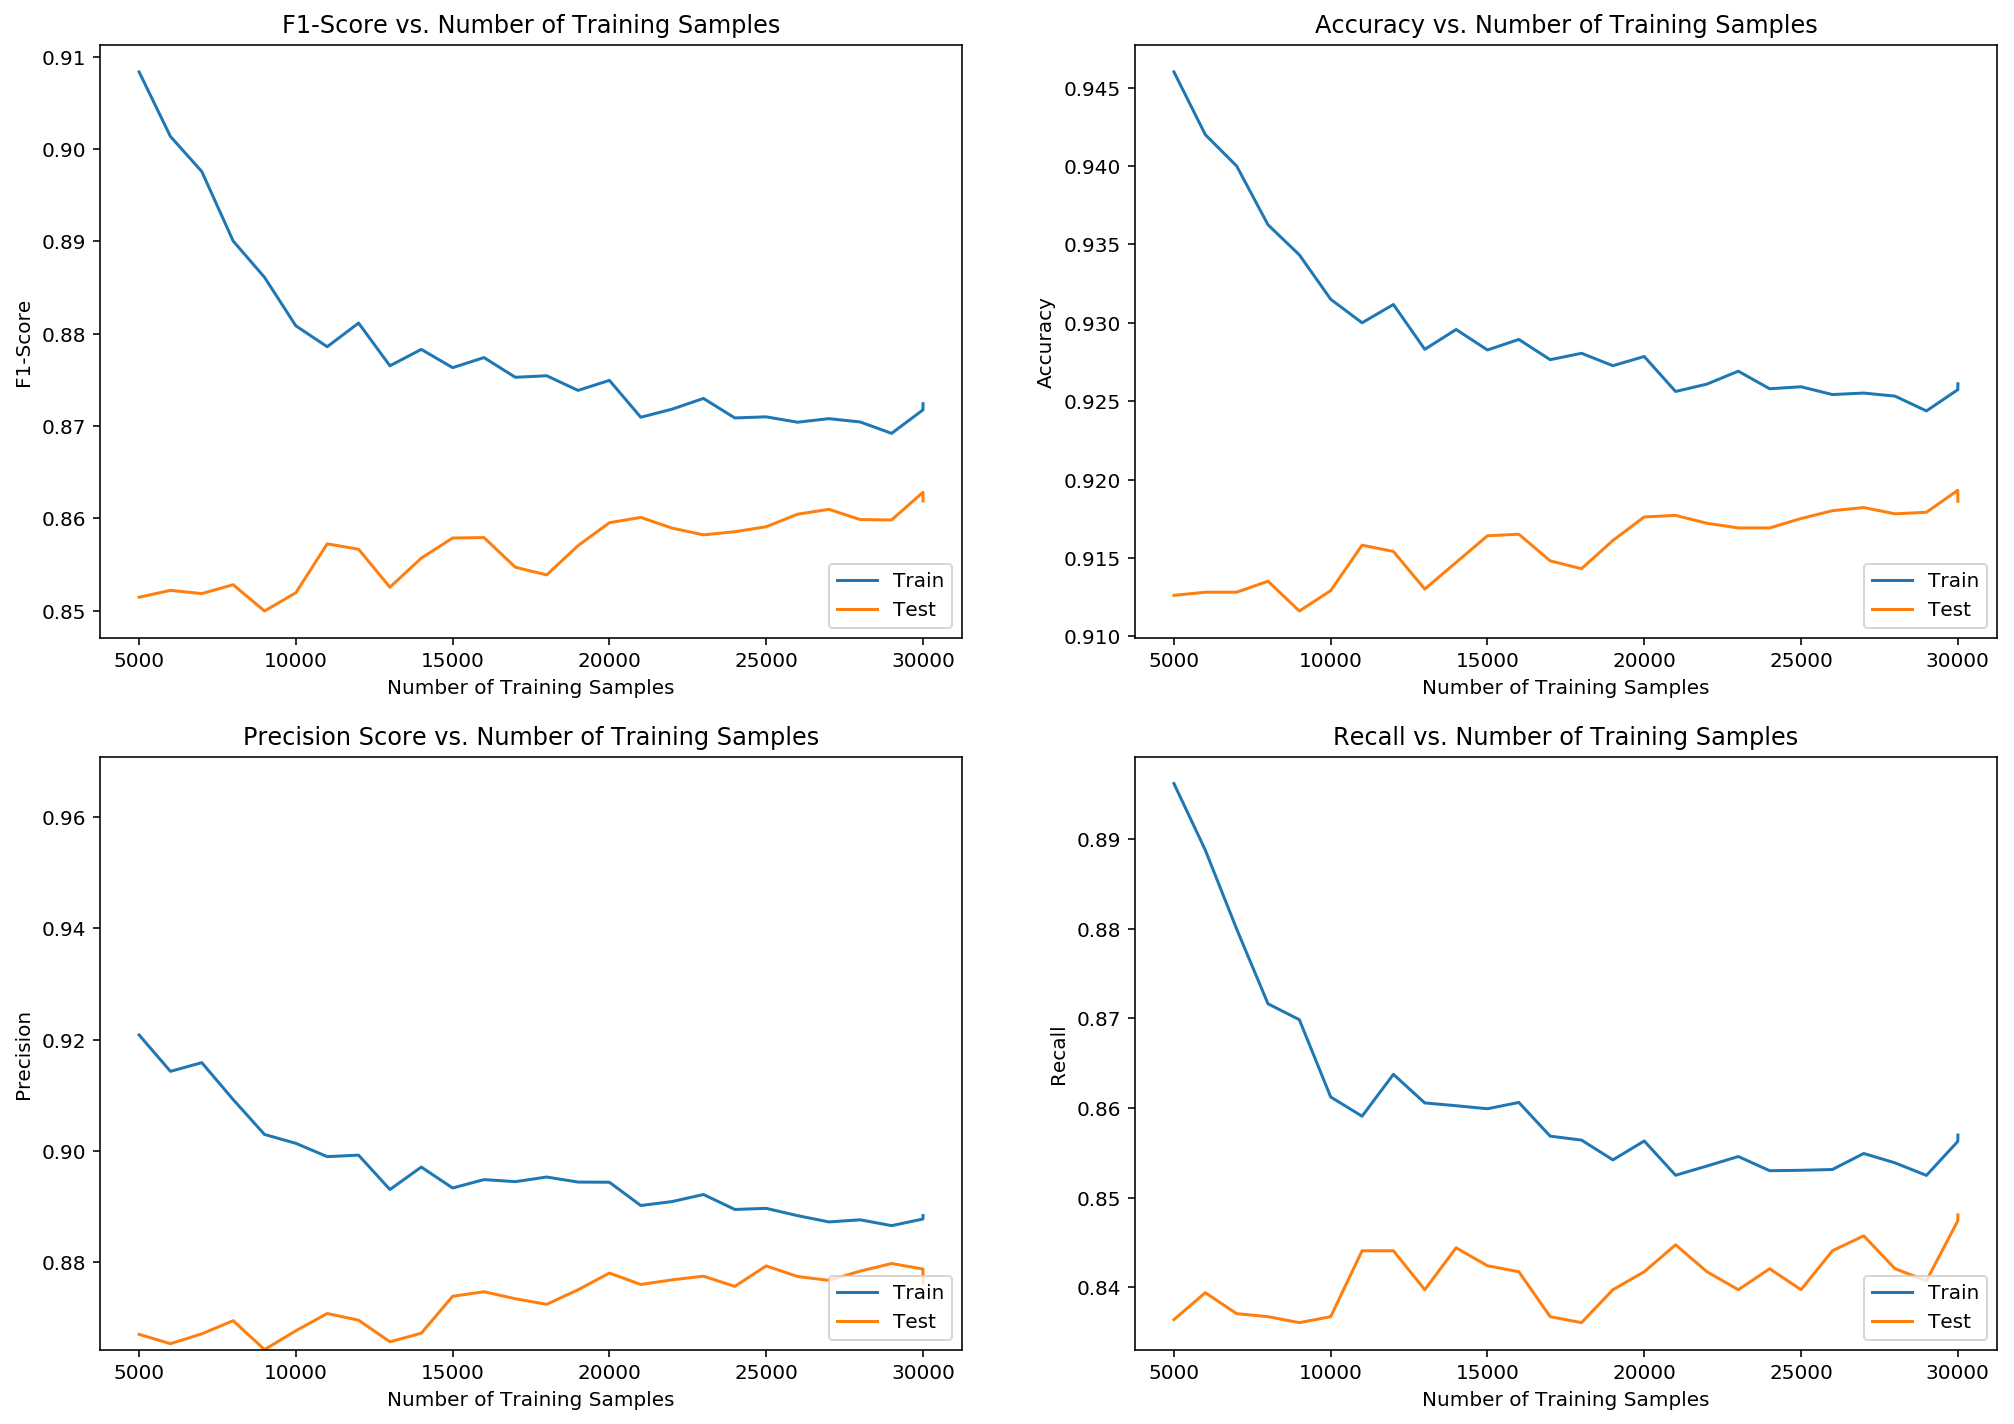

In [71]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(xgb_body, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()